In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler

In [2]:
prod_df = pd.read_excel("./data/Prod_rev1.xlsx")

In [3]:
for col in prod_df.columns:
    try:
        new_col = prod_df[col].replace("-", None).astype(float)
        prod_df[col] = new_col
    except:
        print(f"'{col}' is not convertible to Float")

'Date' is not convertible to Float
'M/C' is not convertible to Float
'Ton' is not convertible to Float
'Status' is not convertible to Float
'ItemId' is not convertible to Float
'ItemName' is not convertible to Float
'Material Code' is not convertible to Float
'Material Name' is not convertible to Float
'M/B  Code' is not convertible to Float
'M/B  Name' is not convertible to Float
'Colour' is not convertible to Float
'Customer' is not convertible to Float
'Group Industry' is not convertible to Float
'Die  No' is not convertible to Float
'Shief' is not convertible to Float
'Unnamed: 200' is not convertible to Float


In [4]:
# Calculate unplanned downtime by summing downtime of each category
prod_df['Unplanned stop time'] = prod_df['Down mold'] + prod_df['Up mold'] + prod_df['Setup equipment'] + prod_df['Adjust setup'] + prod_df['Qc accepted time'] + prod_df['Robot problem'] + prod_df['Adjust mc'] + prod_df['Change filter'] + prod_df['Change insert'] + prod_df['Change mat'] + prod_df['Change Date'] + prod_df['Clean machine'] + prod_df['Clean mold'] + prod_df['Clean screw'] + prod_df['Hopper problem'] + prod_df['Jig problem'] + prod_df['M/C problem'] + prod_df['Mold problem'] + prod_df['Nozzle Leak'] + prod_df['Clogged Gauge'] + prod_df['Part attached mold '] + prod_df['Power failure '] + prod_df['Contaminated pellets'] + prod_df['Pellets do not drop'] + prod_df['Mold waiting '] + prod_df['Packing waiting'] + prod_df['Assembly part waiting '] + prod_df['Waiting for crane '] + prod_df['Mold mounting waiting'] + prod_df['Waiting to adjust work'] + prod_df['Water leak '] + prod_df['Pellet drying'] + prod_df['Gauge pluged '] + prod_df['Waiting for pellets '] + prod_df['Runner attached mold '] 

C:\Users\Admin\AppData\Local\Temp\ipykernel_12480\2837624475.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  prod_df['Unplanned stop time'] = prod_df['Down mold'] + prod_df['Up mold'] + prod_df['Setup equipment'] + prod_df['Adjust setup'] + prod_df['Qc accepted time'] + prod_df['Robot problem'] + prod_df['Adjust mc'] + prod_df['Change filter'] + prod_df['Change insert'] + prod_df['Change mat'] + prod_df['Change Date'] + prod_df['Clean machine'] + prod_df['Clean mold'] + prod_df['Clean screw'] + prod_df['Hopper problem'] + prod_df['Jig problem'] + prod_df['M/C problem'] + prod_df['Mold problem'] + prod_df['Nozzle Leak'] + prod_df['Clogged Gauge'] + prod_df['Part attached mold '] + prod_df['Power failure '] + prod_df['Contaminated pellets'] + prod_df['Pel

In [5]:
i99_df = prod_df[prod_df['M/C'] == 'I-099'].copy()

In [6]:
i99_downtime = i99_df[['Date', 'Unplanned stop time']].groupby('Date').sum()

### Time Value Imputations

In this project, we will apply the trend and seasonality decomposition method to impute missing dates in our dataset.

In [8]:
# Get dates that are not included in the dataset
date_range = pd.date_range(start=i99_downtime.index.min(), end=i99_downtime.index.max(), freq="D")
missing_dates = date_range[~date_range.isin(i99_downtime.index)]

In [9]:
# Decompose time-series data into trends and seasonalities
unplanned_result = seasonal_decompose(i99_downtime['Unplanned stop time'], model="additive", period=12, extrapolate_trend='freq')

In [10]:
# Fill NaN trends using forward-filling method
unplanned_trend = unplanned_result.trend.reindex(date_range)
unplanned_trend_filled = unplanned_trend.ffill()

In [11]:
# Fill NaN seasonalities using forward-filling method
unplanned_seasonal = unplanned_result.seasonal.reindex(date_range)
unplanned_seasonal_filled = unplanned_seasonal.ffill()

In [12]:
# Get imputed data by trend + seasonality + residual
imputed_unplanned = unplanned_trend_filled + unplanned_seasonal_filled + unplanned_result.resid.reindex(date_range).fillna(0)

In [13]:
# Set imputed values less than 0 to 0
imputed_unplanned[imputed_unplanned < 0] = 0

In [14]:
imputed_downtime = pd.DataFrame({'Unplanned stop time': imputed_unplanned})

### Preprocessing

In [15]:
# train-test split for time series
train_set = imputed_downtime['Unplanned stop time'][:300].values.astype('float')
train_set.shape

(300,)

In [16]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_set_norm = scaler.fit_transform(train_set.reshape(-1, 1))

#convert np to tensor
train_set_norm = torch.FloatTensor(train_set_norm).view(-1)

In [17]:
#define function to create training set (ws days -> 1 day)
def create_data(seq, label):
    x_out, y_out = [], []
    #array to hold the out
    for i in range(seq.shape[0] - label):
        x = seq[i:i+label]          # 30 days in the past
        y = seq[i+label:i+label+1]  # next day
        x_out.append(x)
        y_out.append(y)
    
    
    return np.array(x_out), np.array(y_out)

In [18]:
#define window size
ws = 90 #use 60 days in the past to predict the next day

X, y = create_data(train_set_norm, ws)

In [19]:
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()

### Modeling

In [20]:
import torch.nn as nn

class LSTM_model(nn.Module):
    def __init__(self, input_s = 1, hs = 50, num_layers=1, output_size = 1):
        super().__init__()
        self.hs = hs
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_s, hs, num_layers, batch_first=True)  #LSTM will automatically create W(s) for us
        self.linear = nn.Linear(hs, output_size)  #take output of LSTM, project to prediction
        
    def forward(self, input_):
        h0 = torch.zeros(self.num_layers, input_.size(0), self.hs)
        c0 = torch.zeros(self.num_layers, input_.size(0), self.hs)

        # out, _ = self.lstm(input_.reshape(input_.shape[0], 1, -1)) #30, 1, 1
        out, _ = self.lstm(input_, (h0, c0))
        out    = self.linear(out[:, -1, :])  #30, 100
        return out

In [21]:
torch.manual_seed(42)
model = LSTM_model(num_layers=2)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

c:\Users\Admin\anaconda3\envs\dsai\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
epochs = 500
prev_loss = np.inf
model_path = "./model/lstm.pt"

for i in range(1, epochs+1):
    
    # tuple-unpack the chaky_data set
    y_pred = model(X.unsqueeze(-1)).squeeze()
    loss = criterion(y_pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
        
    # print training result
    if i % 20 == 0:
        curr_loss = loss.item()
        print(f'Epoch: {i:2} Loss: {curr_loss:10.8f}')

        if curr_loss < prev_loss:
            torch.save(model.state_dict(), model_path)
            prev_loss = curr_loss

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([210, 1])) that is different to the input size (torch.Size([210])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 20 Loss: 0.61448365
Epoch: 40 Loss: 0.57976937
Epoch: 60 Loss: 0.54437470
Epoch: 80 Loss: 0.50708109
Epoch: 100 Loss: 0.46658078
Epoch: 120 Loss: 0.42134857
Epoch: 140 Loss: 0.36960623
Epoch: 160 Loss: 0.30945083
Epoch: 180 Loss: 0.23960036
Epoch: 200 Loss: 0.16227326
Epoch: 220 Loss: 0.09159406
Epoch: 240 Loss: 0.05987719
Epoch: 260 Loss: 0.05953756
Epoch: 280 Loss: 0.05907721
Epoch: 300 Loss: 0.05908368
Epoch: 320 Loss: 0.05907592
Epoch: 340 Loss: 0.05907508
Epoch: 360 Loss: 0.05907430
Epoch: 380 Loss: 0.05907352
Epoch: 400 Loss: 0.05907274
Epoch: 420 Loss: 0.05907192
Epoch: 440 Loss: 0.05907110
Epoch: 460 Loss: 0.05907025
Epoch: 480 Loss: 0.05906938
Epoch: 500 Loss: 0.05906850


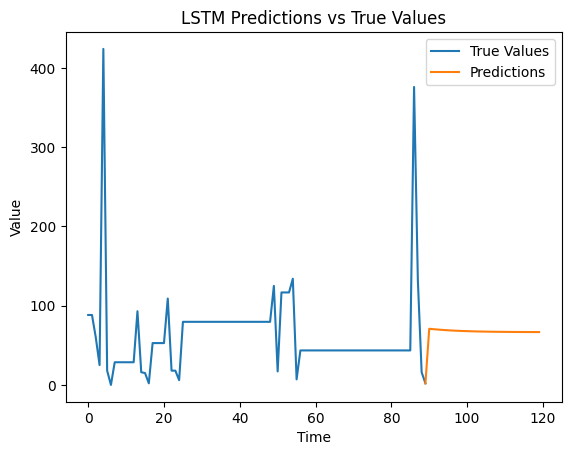

In [27]:
pred_range = 30
ref_set = train_set[-ws:]
inf_set = train_set_norm[-ws:]
inf_outputs = []
inf_output = None
fig_path = './figure/downtime_pred.png'

# Iteratively predict for next day using the inference set and previous predictions
with torch.no_grad():
    for i in range(pred_range):
        if inf_output:
            inf_set = torch.cat((inf_set[-ws+1:], torch.FloatTensor([inf_output])))
        inf_output = model(inf_set.unsqueeze(0).unsqueeze(-1)).squeeze().item()
        inf_outputs.append(inf_output)

inf_outputs = np.array(inf_outputs).reshape(-1, 1)
inf_outputs = scaler.inverse_transform(inf_outputs).flatten().tolist()
inf_outputs.insert(0, ref_set[-1])

# Plot the true values and the predictions
plt.plot(ref_set, label="True Values")
plt.plot(range(ws - 1, ws - 1 + len(inf_outputs)), inf_outputs, label="Predictions")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.title("LSTM Predictions vs True Values")

plt.savefig(fig_path)
plt.show()
plt.close()